In [2]:
#Import packages
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
import seaborn as sns

### Calculating the Bayesian Optimal estimator

We assume that all students have a latent quality $W$, their scores $\hat{W^A},\hat{W^B}$ are respectively the rating scores of college A and B. These ratings scores are the sum of the latent quality and a noise term $\varepsilon$ drawn indepdently at each college, i.e. 
\begin{equation}
   \forall s \in S, \text{ for } C \in \{A,B\}, \widehat{W^C_s} = \varepsilon_s^C + W_s 
\end{equation}
where $S$ is the student set and $s$ is an arbitrary student. Moreover, we assume that the latent qualities of all students are drawn from a (group-indepedent) normal distribution, the noises are also normally distributed and depend on the group:
\begin{equation}
     \forall s \in S, \text{ for } C \in \{A,B\}, W_s \sim \mathcal{N}(0,\chi^2), \varepsilon^C_s \sim \mathcal{N}(0,\sigma^2_{G(s)}).
\end{equation}
$\hat{W}_s^C$ then is a normal distribution with mean $0$ and variance $\chi_{G(s)}^2 = \chi^2 + \sigma^2_{G(s)}$.

In this notebook, we will calculate the conditional expectation $E[W_s|\widehat{W_s^A},\widehat{W_s^B}<P_B]$. 

This conditional expectation can be rewritten as

$$E[W_s|\widehat{W_s^A},\widehat{W_s^B}<P_B] = \int_R w \frac{f_{W_s,\widehat{W_s^A},\widehat{W_s^B} < P_B}(w,w_A,w_B < P_B)}{f_{\widehat{W_s^A},\widehat{W_s^B} < P_B}(w_A,w_B < P_B)} dw$$

The joint distribution in the numerator $f_{W_s,\widehat{W_s^A},\widehat{W_s^B} < P_B}(w,w_A,w_B < P_B)$ can be rewritten as 

$$f_{W_s,\widehat{W_s^A},\widehat{W_s^B} < P_B}(w,w_A,w_B < P_B) = \phi(\frac{w_A - w}{\sigma_{G(s)}}) \Phi(\frac{P_B- w}{\sigma_{G(s)}}) \phi(\frac{w}{\chi})$$

where $\phi,\Phi$ are respectively the pdf and cdf of the standard normal distribution variable $Z$. 

Thus we define the following function to calculate this joint distribution


In [3]:
def joint_dist(w,w_a,p_b,chi,sigma):
    return norm.pdf(w,0,chi)*norm.pdf((w_a - w),0,sigma)*norm.cdf((p_b-w),0,sigma)

where `chi,sigma` are repspectively $\chi,\sigma_{G(s)}$.

Using the fact that $(\widehat{W_s^A},\widehat{W_s^B})$ is joint Gaussian, the joint distribution $f_{\widehat{W_s^A},\widehat{W_s^B} < P_B}(w_A,w_B < P_B)$ in the denominator can be rewritten as

$$f_{\widehat{W_s^A},\widehat{W_s^B} < P_B}(w_A,w_B < P_B) = f_{\widehat{W_s^B} < P_B|\widehat{W^A_s}}(w_B < P_B|w_A) f_{\widehat{W^A_s}}(w_A).$$

We therefore define the following function to calculate the joint distribution $f_{\widehat{W_s^A},\widehat{W_s^B} < P_B}(w_A,w_B < P_B)$

In [4]:
def gaussian_denominator(w_a,P_B,chi,sigma):
    mean_cond_dist = chi**2/(chi**2 + sigma**2)*w_a
    var_cond_dist = (sigma**4 + 2*sigma**2*chi**2)/(chi**2 + sigma**2)
    return norm.cdf(P_B,mean_cond_dist,np.sqrt(var_cond_dist))*norm.pdf(w_a,0,np.sqrt(sigma**2 + chi**2))

In order to calculate the conditional expectation, we need to calculate 

$$E[W_s|\widehat{W_s^A},\widehat{W_s^B}<P_B] =  \frac{\int_R w\phi(\frac{w_A - w}{\sigma_{G(s)}}) \Phi(\frac{P_B- w}{\sigma_{G(s)}}) \phi(\frac{w}{\chi})dw}{f_{\widehat{W_s^A},\widehat{W_s^B} < P_B}(w_A,w_B < P_B)}  $$

We will calculate the numerator using numerical integration using `scipy.integrate`

In [15]:
#Define function inside the integral
def integrand(w,w_a,p_b,chi,sigma):
    return w*norm.pdf(w,0,chi)*norm.pdf((w_a - w),0,sigma)*norm.cdf((p_b-w),0,sigma)#/gaussian_denominator(w_a,p_b,chi,sigma)

In [16]:
#Calculate the integral with respect to w
def exp_val(w_a,p_b,chi,sigma):
    return quad(integrand, -np.inf,np.inf,args=(w_a,p_b,chi,sigma))

The conditional expectation function therefore is


In [21]:
def bayesian_est(w_a,p_b,chi,sigma):
    return exp_val(w_a,p_b,chi,sigma)[0]/gaussian_denominator(w_a,p_b,chi,sigma)

For comparison, we also define the naive bayesian estimator as  $E[W_s|\widehat{W_s^A}]$

In [23]:
def bayesian_naive(w_a,chi,sigma):
    return chi**2/(chi**2+sigma**2)*w_a

#### Data generator function

We generate $W$ and $\varepsilon_A,\varepsilon_B$ according to Gaussian distributions with $\chi,\sigma$ respectively to be the standard deviation of $W$ and $\varepsilon_A,\varepsilon_B$.

In [18]:
#Generate data, return data and the parameter chi, sigma
def data_generator(chi=4,sigma=2,n=100000,mu_w = 0, mu_epsilon = 0):
    #Generate value
    W = np.random.normal(mu_w,chi,n)
    epsilon_a = np.random.normal(mu_epsilon,sigma,n)
    epsilon_b = np.random.normal(mu_epsilon,sigma,n)
    W_A = W + epsilon_a
    W_B = W + epsilon_b
    #Generate cutoff value of College B (Here we choose 75 percentile)
    P_B = np.percentile(W_B,75)
    return W,W_A,W_B,P_B,chi,sigma


In [6]:
#Randomized a student
def randomized_student(W,W_A):
    #Select a random student
    student_index = np.random.randint(0,9999)
    w = W[student_index]
    w_a = W_A[student_index]
    return student_index,w,w_a

#### Test for corner case

We first test whether or not the theoretical conditional probability $f_{W_s|\widehat{W_s^A},\widehat{W_s^B} < P_B}(w|w_A,w_B < P_B)$ is similar to the kernel density estimator from our generated data

In [77]:
#Generate daata
W,W_A,W_B,P_B,chi,sigma = data_generator(n=1000000)

In [84]:
w_a = 5
P_B = 10
h = 1e-1
test_w = W[(W_A < w_a + h)& (W_A > w_a - h)&(W_B < P_B)]
len(test_w)

9434

In [85]:
w = np.arange(-15,15,0.1)
joint_distribution = joint_dist(w,w_a,P_B,chi,sigma)
cond_distribution = joint_dist(w,w_a,P_B,chi,sigma)/gaussian_denominator(w_a,P_B,chi,sigma)

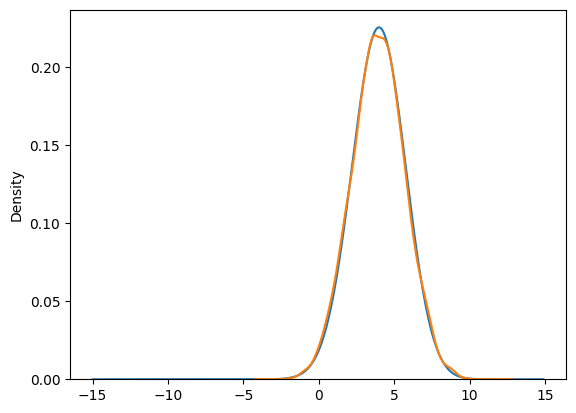

In [86]:
plt.figure()
plt.plot(w,cond_distribution)
sns.kdeplot(test_w)
#ax = plt.gca()


plt.show()

As the value of $P_B$ becomes large, we will expect the value of the conditional expectation $E[W_s|\widehat{W_s^A},\widehat{W_s^B}<P_B]$ to become close to the value of the conditoinal expectation $E[W_s|\widehat{W_s^A}]$

In [87]:
P_B = 1
print(f'P_B is {P_B}')
print(f'The value of Bayesian Estimator is {bayesian_est(w_a,P_B,chi,sigma)}')
print(f'The value of Bayesian Naive is {bayesian_naive(w_a,chi,sigma)}')

P_B is 1
The value of Bayesian Estimator is 2.067486049762061
The value of Bayesian Naive is 4.0


In [88]:
P_B = 10
print(f'P_B is {P_B}')
print(f'The value of Bayesian Estimator is {bayesian_est(w_a,P_B,chi,sigma)}')
print(f'The value of Bayesian Naive is {bayesian_naive(w_a,chi,sigma)}')

P_B is 10
The value of Bayesian Estimator is 3.9604454117919654
The value of Bayesian Naive is 4.0


In [89]:
P_B = 100
print(f'P_B is {P_B}')
print(f'The value of Bayesian Estimator is {bayesian_est(w_a,P_B,chi,sigma)}')
print(f'The value of Bayesian Naive is {bayesian_naive(w_a,chi,sigma)}')

P_B is 100
The value of Bayesian Estimator is 4.000000000000008
The value of Bayesian Naive is 4.0


We now consider the case where the value of $\chi$ and $\sigma$ become extreme.

The first case would be when $\chi$ become really large in comparison to $\sigma$. In such a case, most of the variation of the value of $\widehat{W_s^A}$ and $\widehat{W_s^B}$ is explained by the variation of $W$. The Bayesian estimator $E[W_s|\widehat{W_s^A},\widehat{W_s^B}<P_B]$ is expected to be close to the value of $\widehat{W_s^A}$ if the $\widehat{W_s^A} <P_B$. This is only accurate when the value of $\widehat{W_s^A}$ is within a reasonable range. If $\widehat{W_s^A}$ falls out of this range, the numerical error will cause the conditional expectation become small due to the value of $\phi(\frac{w_A - w}{\sigma_{G(s)}})$ becomes extremely small.

In [109]:
#Here we select sigma = 1 and chi = 10000
W,W_A,W_B,P_B,chi,sigma = data_generator(sigma=1,chi=10000)
w_a = 10
P_B = 100

In [110]:
bayesian_est(w_a,P_B,chi,sigma)

9.999999899513435

The second case would be when $\sigma$ become really large in comparison to $\chi$. Both of the scores are mostly noise. The conditional expectation would be nothing but the theoretical mean of $W$, in this case $0$.

In [90]:
#Here we select chi = 1 and sigma = 10000
W,W_A,W_B,P_B,chi,sigma = data_generator(chi=1,sigma=10000)
w_a = 200
P_B = -5

In [91]:
bayesian_est(w_a,P_B,chi,sigma)

-7.782038273697496e-05

irregardless of the values of $w_a$ and $P_B$, the Bayesian estimator is close to $0$.
